<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from torch import nn

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

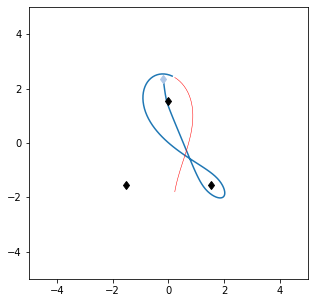

Charges are [-0.20083667 -0.51991506 -0.88864394]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [8]:
# The inputs for this model would be the location of each particle (p1, p2, p3, p4), the initial charges for p2, p3, and p4
# The output is a set of charges at every t, for the maximum

# 1. Sort the input sequences by length <- Saving this for optimization later
# 2. Pad the input sequences to the maximum length per batch, thus minimizing the amount of padding in the input
  # This is 110
# 3. Put the input sequences into a dataloader, for shuffling and batching

# Maybe sorting isn't even necessary, because the sequences are not that long to begin with.
# Padding with 0s is usually done, but this could reduce accuracy for longer sequences, as most examples will have 0 at the end.
# I think we can combat this by not calculating loss for the sequence past its usefulness.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [10]:
simulation_train_tensor_no_padding = torch.zeros(800, 90, 1, 2)
simulation_train_tensor_with_padding = torch.zeros(800, 110, 1, 2)
simulation_train_no_nothing = []
for i in range(800):
  tensor = torch.Tensor(simulation_train[i])
  simulation_train_no_nothing.append(tensor)
  simulation_train_tensor_with_padding[i] = F.pad(tensor, (0,0,0,110 - tensor.shape[0])).unsqueeze(dim=1)
  simulation_train_tensor_no_padding[i] = tensor[-90:, :].unsqueeze(dim=1)

simulation_eval = torch.zeros(100, 90, 1, 2)
simulation_eval_no_nothing = []
for i in range(100):
  tensor = torch.Tensor(simulation_valid[i])
  simulation_eval_no_nothing.append(tensor)
  simulation_eval[i] = tensor[-90:, :].unsqueeze(dim=1)


In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, input_tensor, output_tensor):
        self.input_tensor = input_tensor
        self.output_tensor = output_tensor

    def __len__(self):
        return len(self.input_tensor)

    def __getitem__(self, idx):
        return self.input_tensor[idx], self.output_tensor[idx].unsqueeze(dim=0)

train_dataset = CustomDataset(simulation_train_tensor_no_padding, torch.Tensor(charges_train))
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

train_dataset_padding = CustomDataset(simulation_train_tensor_with_padding, torch.Tensor(charges_train))
train_dataloader_padding = DataLoader(train_dataset_padding, batch_size=1, shuffle=True)

eval_dataset = CustomDataset(simulation_eval, torch.Tensor(charges_valid))
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

train_no_nothing = CustomDataset(simulation_train_no_nothing, torch.Tensor(charges_train))
train_no_nothing_dataloader = DataLoader(train_no_nothing, batch_size=1, shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  from ipykernel import kernelapp as app


## Model Implementation

In [224]:
class simpleModel(nn.Module):
  def __init__(self):
    super(simpleModel, self).__init__()

    self.linear = nn.Linear(180, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linout = nn.Linear(128, 3)
    self.relu = nn.ReLU()

    self.dropout = nn.Dropout(p=0.2)

  def forward(self, input):
    out = self.linear(input)
    out = self.dropout(out)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.dropout(out)
    out = self.relu(out)
    out = self.linout(out)
    return out

## Model Training

In [226]:
# Define runtime device
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Model definition
sm = simpleModel().to(dev)

criterion = nn.L1Loss()
learning_rate = 0.005
optimizer = torch.optim.SGD(sm.parameters(), lr = learning_rate)
num_epochs = 200
dataloader = train_dataloader

lossPerEpoch = np.empty((num_epochs, 1))
errorPerEpoch = np.empty((num_epochs, 3))

for epoch in range(num_epochs):
  total_loss = 0
  total_eval_loss = 0
  total_error = 0

  # Set in train mode
  sm.train()

  # Train the model
  iterator = iter(dataloader)
  for i in range(len(iterator)):
    x, y = next(iterator)
    
    # Move to GPU
    x = x.to(dev)
    y = y.to(dev)

    # Propagate forward
    output = sm(torch.flatten(x[0]))

    # Compute loss
    loss = criterion(output, y[0][0])
    total_loss += loss.item()

    # Store error per for each prediction [c2 c3 c4]
    expected = y[0][0].cpu().numpy()
    predicted = output.cpu().detach().numpy()
    total_error += expected - predicted
    
    # Backward propagate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  
  # Set in eval mode
  sm.eval()

  # Evaluate loss on verification set
  eval_iterator = iter(eval_dataloader)
  for i in range(len(eval_iterator)):
    with torch.no_grad():
      x, y = next(eval_iterator)
    
      # Move to GPU
      x = x.to(dev)
      y = y.to(dev)
    
      # Propagate forward
      output = sm(torch.flatten(x[0]))
    
      # Compute loss
      loss = criterion(output, y[0][0])
      total_eval_loss += loss.item()
        
  average_training_loss = total_loss / len(iterator)
  average_eval_loss = total_eval_loss / len(eval_iterator)
  average_training_error = total_error / len(iterator)
    
  lossPerEpoch[epoch] = average_training_loss
  errorPerEpoch[epoch] = average_training_error

  print(f'epoch: {epoch+1}, mean training loss: {average_training_loss}, mean eval loss: {average_eval_loss}')

#TODO: Might need to zero out the hidden state of lstm, but maybe not
#TODO: Experiment with num_layers

epoch: 1, mean training loss: 0.21753767581889405, mean eval loss: 0.18123919911682607
epoch: 2, mean training loss: 0.1708584457798861, mean eval loss: 0.13081471281126142
epoch: 3, mean training loss: 0.15409019902930596, mean eval loss: 0.1348356477729976
epoch: 4, mean training loss: 0.14426918632059824, mean eval loss: 0.12327780270949006
epoch: 5, mean training loss: 0.1404320994007867, mean eval loss: 0.12995587119832636
epoch: 6, mean training loss: 0.136489473877009, mean eval loss: 0.11538689350709319
epoch: 7, mean training loss: 0.12998093458299992, mean eval loss: 0.12395235266536474
epoch: 8, mean training loss: 0.12619369945838116, mean eval loss: 0.11363583229482174
epoch: 9, mean training loss: 0.12761973660788498, mean eval loss: 0.12064028408378363
epoch: 10, mean training loss: 0.12184568454045802, mean eval loss: 0.10369556285440922
epoch: 11, mean training loss: 0.12258571619284339, mean eval loss: 0.10773701770231128
epoch: 12, mean training loss: 0.1237696636409

In [ ]:
# without padding :epoch: 25, mean training loss: 0.08195400983095169, mean eval loss: 0.09817712453918324
# epoch: 100, mean training loss: 0.0861954316496849, mean eval loss: 0.10278522804379463

In [ ]:
# without any cutting : epoch: 56, mean training loss: 0.07555700838565826, mean eval loss: 0.08626986091025174
# With linear layer: epoch: 56, mean training loss: 0.07898687571287155, mean eval loss: 0.08656595157459378
# With reLU + linear layer: epoch: 56, mean training loss: 0.08114010095596313, mean eval loss: 0.09263360679149628

## Evaluation

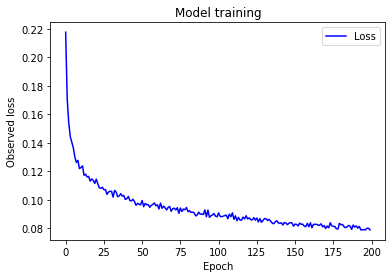

In [227]:
# Plot the loss curve
plt.figure()
plt.plot(range(num_epochs), lossPerEpoch, "b-", label="Loss")
#plt.plot(range(num_epochs), stdPerEpoch, "g-", label="Standard Deviation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Observed loss")
plt.title("Model training")
plt.show()

In [228]:
import random

# number of example predictions
nrExamplePredictions = 100

# Set model to eval mode
sm.eval()

predictionError = np.empty((nrExamplePredictions, 3))
for examplePrediction in range(nrExamplePredictions):
    # Get a random index
    index = random.choice(range(len(simulation_test)))
    
    # Get corresponding tensors
    particlePositions = torch.tensor(simulation_test[index][0:90]).type(torch.FloatTensor).to(dev)
    particleCharges = torch.tensor(charges_test[index]).type(torch.FloatTensor).to(dev)
    
    # Forward propagate the particle positions through the model
    with torch.no_grad():
        predictedCharges = sm(torch.flatten(particlePositions))
        
        # Store prediction result in error
        prediction = predictedCharges.cpu().numpy()
        expected = particleCharges.cpu().numpy()
        predictionError[examplePrediction] = expected - prediction
    
    # Print results
    print(f'Predicted charges: {prediction}, Actual charges: {expected}')

Predicted charges: [-0.4302902 -0.2792336 -0.3866466], Actual charges: [-0.38919482 -0.2812407  -0.2140717 ]
Predicted charges: [-0.37426692 -0.3873792  -0.69401485], Actual charges: [-0.22984149 -0.3395736  -0.72089595]
Predicted charges: [-0.8425971  -0.75834197 -0.4622907 ], Actual charges: [-0.9276323  -0.81764734 -0.37524036]
Predicted charges: [-0.26867318 -0.8120596  -0.71431565], Actual charges: [-0.28947157 -0.83868444 -0.84986407]
Predicted charges: [-0.58866084 -0.40240937 -0.53330004], Actual charges: [-0.55181694 -0.35807365 -0.5719679 ]
Predicted charges: [-0.12367035 -0.19310841 -0.7926307 ], Actual charges: [-0.03399318 -0.08961437 -0.9840343 ]
Predicted charges: [-0.4091441  -0.6679189  -0.56195325], Actual charges: [-0.5122477 -0.5047246 -0.5907416]
Predicted charges: [-0.5787402  -0.4065798  -0.74693024], Actual charges: [-0.5532922  -0.41946065 -0.80242974]
Predicted charges: [-0.19660057 -0.93019855 -0.15539157], Actual charges: [-0.14161779 -0.8942212  -0.14785743

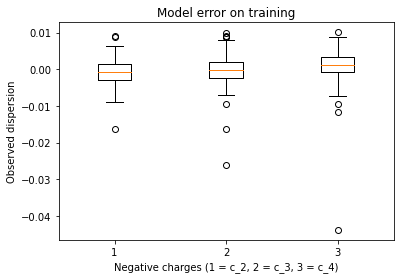

In [229]:
# Plot the error
plt.figure()
plt.boxplot(errorPerEpoch)
plt.xlabel("Negative charges (1 = c_2, 2 = c_3, 3 = c_4)")
plt.ylabel("Observed dispersion")
plt.title("Model error on training")
plt.show()

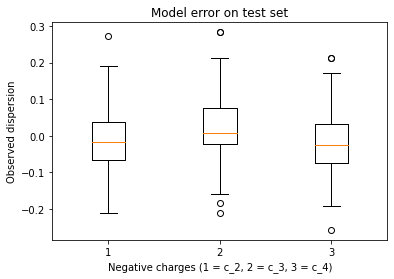

In [230]:
# Plot model error on test set
plt.figure()
plt.boxplot(predictionError)
plt.xlabel("Negative charges (1 = c_2, 2 = c_3, 3 = c_4)")
plt.ylabel("Observed dispersion")
plt.title("Model error on test set")
plt.show()

# Task 3.2

## Data Handling and Preprocessing

In [ ]:
#todo
# Let's add the static input at every call of the model, or design it in a way that has a seperate method for the static data (per simulation) for 3.2

## Model Implementation

In [ ]:
#todo

## Model Training

In [ ]:
#todo

## Evaluation

In [ ]:
#todo